<img src='./img/logo_header.png' alt='Logo EU Copernicus EUMETSAT' align='right' width='100%'></img>

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./51_CAMS_GFAS_FRPFIRE.ipynb"><< 51 - CAMS GFAS FRFPFIRE </a><span style="float:right;"><a href="./62_CEMS_GEFF_FWI_harmonized_danger_classes.ipynb">62 - CEMS GEFF FWI harmonized danger classes >></a></span>

<br>

# 6.1 CEMS GEFF FWI Data Overview 
# Global ECMWF Fire Forecasting

###  Example Portugal fires in July 2020

The European Centre for Medium-range Weather Forecasts ([ECMWF](https://www.ecmwf.int/)) produces daily fire danger forecasts and reanalysis products for the Copernicus Emergency Management Services ([CEMS](https://emergency.copernicus.eu/)). Activities are funded funded through a third-party agreement with the European Commission’s Joint Research Centre (JRC).

The modelling system that generates the fire data products is called Global ECMWF Fire Forecast ([GEFF](\href{https://git.ecmwf.int//projects/CEMSF/repos/geff/browse)) and it is based on the Canadian Fire Weather index as well as the US and Australian fire danger systems.

## Data overview

Fire danger data products:

- **GEFF-RT** provides the following *real-time* fire danger forecasts using weather forcings from the latest model cycle of the ECMWF’s Integrated Forecasting System (IFS):
    - *rt_hr*: high-resolution deterministic (~9 Km, with 10 days lead time) and 
    - *rt_en*: lower-resolution probabilistic (~18Km, with 15 days lead time)
- **GEFF-RE** provides historical records of global fire danger conditions (*reanalysis*) from 1980 to the present day. This dataset is updated as soon as new ERA-5 data becomes available (~2 months behind real-time) and it is made of four products:
    - *e5_hr*: deterministic model outputs (~28 Km),
    - *e5_en*: probabilistic model outputs (made of 10 ensemble members, ~56 Km),
    - ensemble mean and
    - ensemble spread.
    
All of GEFF data products are under the Copernicus license, which provides users with free, full and open access to environmental data. Please note, the terms `GEFF data`, `EFFIS data` and `GWIS data` are considered synonyms and will be used interchangibly hereafter.

## Data availability

- **geff-rt** data can be requested through an online [form](https://effis.jrc.ec.europa.eu/applications/data-request-form/) and viewed using the following platforms: the European Forest Fire Information System ([EFFIS](https://effis.jrc.ec.europa.eu/static/effis_current_situation/public/index.html)) and the Global Wildfire Information System ([GWIS](https://gwis.jrc.ec.europa.eu/static/gwis_current_situation/public/index.html))
- **geff-re** data are available through the Copernicus Climate Data Store ([CDS](https://cds.climate.copernicus.eu)).

## Event of interest: Portugal fires, 25-27 July 2020

For the purpose of this tutorial, all relevant global data is in the directory `./eodata/cems_geff/global/`. Data for tutorial 01 and 02 are in `./eodata/cems_geff/202007_Portugal/`. 

#### Get the sample data from Zenodo

For educational purposes only, sample datasets are available on the [Zenodo wildfire community](https://zenodo.org/communities/wildfire). These samples provide a sneak peak into GEFF fire danger data.

Instructions:

1. Go to the Zenodo data repository: https://zenodo.org/

2. Click on 'Communities', then type 'Wildfire', then click on 'View'. The page should list several datasets.

3. Click on 'Fire Weather Index - ERA5 HRES', scroll down and download the 'fwi.nc' file.

4. Go back to the 'Wildfire' community page. Click on 'Global ECMWF Fire Forecasting system - sample data for wildfires in Portugal on 25-27 July 2020' (https://doi.org/10.5281/zenodo.4772331)

    a. Scroll down and click on the 'Download' button next to the following file (it may take a while):
    
        - eodata_geff_global.zip
    
    b. Extract the tar files in your working directory.

### Background
A devastating wildfire raged in the municipality of Oleiros and two neighboring municipalities over the period 25-27 July 2020.
(Source: https://www.dw.com/en/portugal-wildfires-state-of-alert/a-54329910).

### Active fires
Most of the active fires detected by the MODIS instruments was in the centre and north of Portugal.

In [6]:
# First of all, we need to import the necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import warnings

warnings.simplefilter(action = "ignore", category = RuntimeWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

In [7]:
# Where did the fire actually occur?
bbox = [350.18, 353.81, 36.78, 42.15]
lon_slice = slice(350.18, 353.81)
lat_slice = slice(42.15, 36.78)

# Let's download Fire Radiative Power from CAMS GFAS: https://apps.ecmwf.int/datasets/data/cams-gfas/

# Open fire radiative power dataset
ds = xr.open_dataset("./eodata/cems_geff/global/frp/CAMS_daily_2020-07-01_2020-07-31.nc")
# Data have global coverage and are bundled in monthly datacubes, we will need to slice in time and space
ds = ds.loc[dict(time = slice('2020-07-25', '2020-07-27'), longitude = lon_slice, latitude = lat_slice)]
frpfire = ds.frpfire
frpfire.values[frpfire.values <= 0] = np.nan

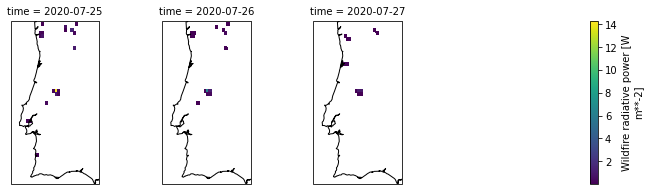

In [8]:
# This is the map projection we want to plot *onto*
map_proj = ccrs.LambertConformal(central_longitude = 352, central_latitude = 39.5)

p = frpfire.plot(transform=ccrs.PlateCarree(),                         # the data's projection
                 col = 'time', col_wrap = 4,                           # multiplot settings
                 subplot_kws = {'projection': map_proj})               # the plot's projection

# We have to set the map's options on all axes
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

### Fire Danger Forecasts
The tutorials in this series will showcase how to use GEFF/EFFIS data to assess the event. For convenience, a schematic representation of the forecast issue dates and leadtimes is provided in the table below ([link to spreadsheet](https://docs.google.com/spreadsheets/d/1o-b4i8hiiNF5_I-L4GbBECA01Pf-0bwtPGJH_WzCn-M/edit?usp=sharing)).

![schematic](./img/portugal_forecast.png)

## Explore the data

In this section we show how to load GEFF datasets and explore the content. We will touch briefly on the different spatial resolutions of each datasets and related implications (e.g. different land-sea mask -> different spatial coverage).

### geff-rt: fire danger forecasts

The GEFF model uses weather forcings from the ECMWF’s Integrated Forecasting System (IFS) to generate fire danger forecasts. Based on the date of a particular event (e.g. 25-27 July 2020) the IFS model cycle used was 47r1.

#### HRES forecast

This dataset provides real-time high-resolution deterministic (~9 Km) fire danger forecasts up to 10 days ahead. Let us explore the content of the sample file.

In [23]:
# Open the dataset
ds_rt_hr = xr.open_dataset("./eodata/cems_geff/global/rt_hr/ECMWF_FWI_20200725_1200_hr.nc")
ds_rt_hr

<xarray.Dataset>
Dimensions:      (lat: 2560, lon: 5120, time: 10)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-25 2020-07-26 ... 2020-08-03
  * lon          (lon) float32 0.0 0.0703125 0.140625 ... 359.85938 359.9297
  * lat          (lat) float32 89.94619 89.87648 ... -89.87648 -89.94619
Data variables:
    fwi          (time, lat, lon) float32 ...
    ffmc         (time, lat, lon) float32 ...
    dmc          (time, lat, lon) float32 ...
    dc           (time, lat, lon) float32 ...
    isi          (time, lat, lon) float32 ...
    bui          (time, lat, lon) float32 ...
    dsr          (time, lat, lon) float32 ...
    danger_risk  (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.5 (http://mpimet.mp...
    Conventions:       CF-1.6
    Reference date:    20200725
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    CDO:               Climate Data Operators version 1.9.5 (http://mpimet.mp...
    history:           Sat Jul 25 06:41:17 2020: ncatted -O -a version,global...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

This dataset has three dimensions: latitude, longitude and time. In the lat/long plane data are distributed on a regular grid (2560 x 5120), while the time dimension is made of 10 levels (each corresponds to a daily forecast estimate). Each cell of this datacube contains only 8 variables: fwi, ffmc, dmc, dc, isi, bui, dsr, danger_risk. 

To plot and run basic operations, it is convenient to convert the dataset to a dataarray by extracting 1 variable, e.g. fwi. 

Remember: 
- DataArray = single multi-dimensional variable and its coordinates
- Dataset = holds multiple variables that potentially share the same coordinates.

In [24]:
# Convert ds to a dataarray extracting only the variable fwi
da_rt_hr = ds_rt_hr.fwi
da_rt_hr

<xarray.DataArray 'fwi' (time: 10, lat: 2560, lon: 5120)>
[131072000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-07-25 2020-07-26 ... 2020-08-03
  * lon      (lon) float32 0.0 0.0703125 0.140625 ... 359.85938 359.9297
  * lat      (lat) float32 89.94619 89.87648 89.80636 ... -89.87648 -89.94619
Attributes:
    units:    -
    title:    Fire Weather Index

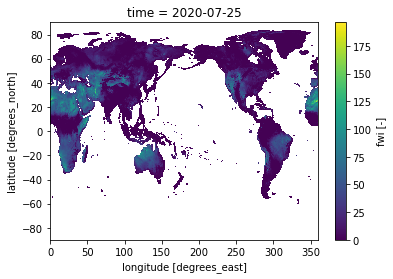

In [25]:
# Plot the first day
da_rt_hr[0].plot();

In [26]:
# Crop over area of interest, note lat = slice(top, bottom), lon = slice(left, right)!
# Use this service to get coordinates: https://boundingbox.klokantech.com/
fwi_rt_hr = da_rt_hr.loc[dict(lat = lat_slice, lon = lon_slice)]

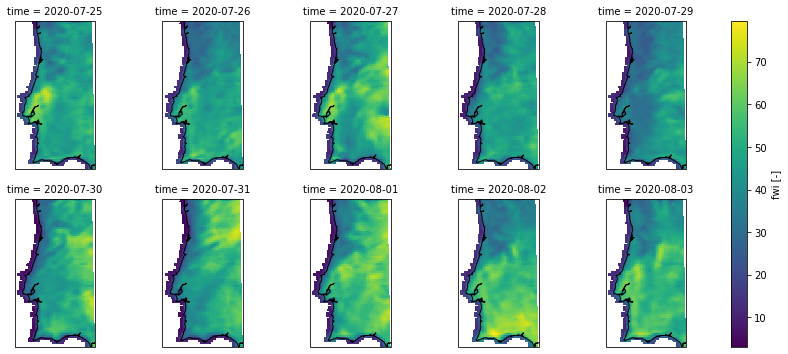

In [27]:
# Plot RT-HR
p = fwi_rt_hr.plot(transform=ccrs.PlateCarree(),
                   col = 'time', col_wrap = 5,
                   subplot_kws = {'projection': map_proj})
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

#### ENS forecast

This dataset provides real-time probabilistic (~18 Km) fire danger forecasts up to 10 days ahead. Each member of the ensemble has similar structure to the HRES but lower resolution.

In [9]:
# Open the dataset
ds_rt_en = xr.open_dataset("./eodata/cems_geff/global/rt_en/ECMWF_FWI_20200725/ECMWF_FWI_20200725_1200_00.nc")
ds_rt_en

<xarray.Dataset>
Dimensions:      (lat: 1280, lon: 2560, time: 15)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-25 2020-07-26 ... 2020-08-08
  * lon          (lon) float32 0.0 0.140625 0.28125 ... 359.71875 359.85938
  * lat          (lat) float32 89.892395 89.753006 ... -89.753006 -89.892395
Data variables:
    fwi          (time, lat, lon) float32 ...
    ffmc         (time, lat, lon) float32 ...
    dmc          (time, lat, lon) float32 ...
    dc           (time, lat, lon) float32 ...
    isi          (time, lat, lon) float32 ...
    bui          (time, lat, lon) float32 ...
    dsr          (time, lat, lon) float32 ...
    danger_risk  (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.5 (http://mpimet.mp...
    Conventions:       CF-1.6
    Reference date:    20200725
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    CDO:               Climate Data Operators version 1.9.5 (http://mpimet.mp...
    history:           Sat Jul 25 07:46:41 2020: ncatted -O -a version,global...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

In [10]:
# Convert ds to a dataarray extracting only the variable fwi
da_rt_en = ds_rt_en.fwi
da_rt_en

<xarray.DataArray 'fwi' (time: 15, lat: 1280, lon: 2560)>
[49152000 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-07-25 2020-07-26 ... 2020-08-08
  * lon      (lon) float32 0.0 0.140625 0.28125 ... 359.71875 359.85938
  * lat      (lat) float32 89.892395 89.753006 ... -89.753006 -89.892395
Attributes:
    units:    -
    title:    Fire Weather Index

This dataset is, again, a datacube with three dimensions: latitude, longitude and time. In the lat/long plane data are distributed on a smaller regular grid (1280 x 2560) compared to the HRES forecast.

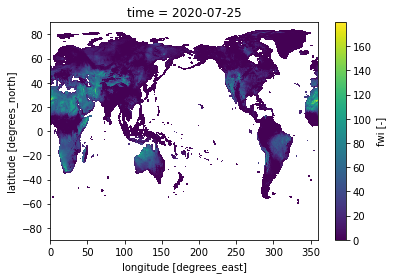

In [11]:
# Plot the first day
da_rt_en[0].plot();

The difference in lower resolution is not evident at this scale, but it will become evident when we explore the same dataset cropped over Portugal.

In [12]:
# Crop over area of interest, note lat = slice(top, bottom), lon = slice(left, right)!
# Use this service to get coordinates: https://boundingbox.klokantech.com/
fwi_rt_en = da_rt_en.loc[dict(lat = lat_slice, lon = lon_slice)]

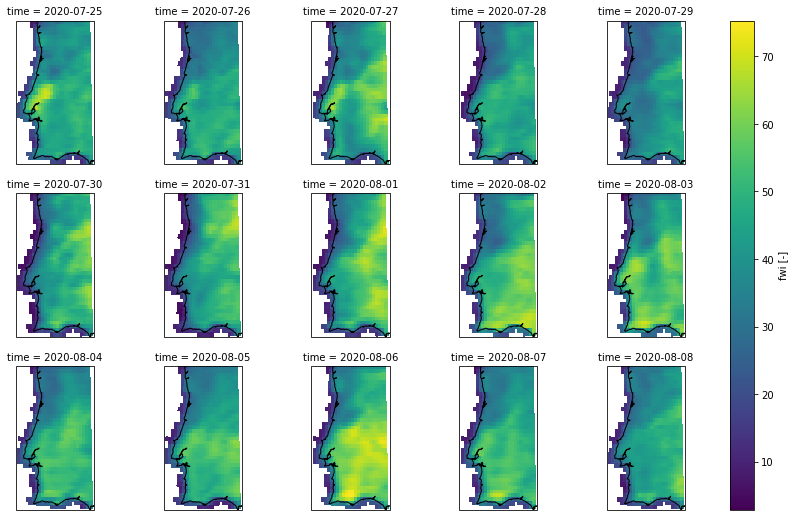

In [13]:
# Plot RT-EN00
p = fwi_rt_en.plot(transform=ccrs.PlateCarree(),
                   col = 'time', col_wrap = 5,
                   subplot_kws = {'projection': map_proj})
for ax in p.axes.flat:
    ax.coastlines()
    ax.set_extent(bbox)

### geff-re: ERA5 based reanalysis of the Fire Weather Index

This dataset provides historical records of global fire danger conditions from 1980 to the present day and it is made of two main types of products: (i) deterministic model outputs (HRES reanalysis), (ii) probabilistic model outputs (made of 10 ensemble members, ENS reanalysis). It is updated as soon as new ERA5 data becomes available (~2 months behind real-time). 

A single reanalysis layer is often used as proxy for observations (e.g. for validating the forecasts). Stacking together consecutive reanalysis estimates, allows to compute temporal trends and other long term statistics.

#### HRES reanalysis

Let's repeat the same operations shown above, this time the dataset has only 1 temporal layer.
The regular grid is smaller (640 x 1280) compared to the HRES/ENS forecasts.

The example below shows how to explore the single layer reanalysis. Examples of how to use a reanalysis datacube will be shown in follow-up tutorials.

In [14]:
# Open the dataset
ds_e5_hr = xr.open_dataset("./eodata/cems_geff/global/e5_hr/ECMWF_FWI_20200725_1200_hr_fwi.nc")
ds_e5_hr

<xarray.Dataset>
Dimensions:  (lat: 640, lon: 1280, time: 1)
Coordinates:
  * time     (time) datetime64[ns] 2020-07-25
  * lon      (lon) float32 0.0 0.28125 0.5625 ... 359.15625 359.4375 359.71875
  * lat      (lat) float32 89.784874 89.5062 89.22588 ... -89.5062 -89.784874
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.9.8 (https://mpimet.m...
    Conventions:       CF-1.6
    history:           Thu Nov 26 09:34:30 2020: cdo --silent -select,name=fw...
    Reference date:    20200725
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....
    CDO:               Climate Data Operators version 1.9.8 (https://mpimet.m...

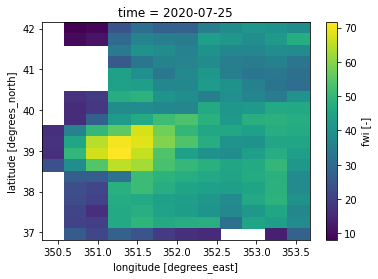

In [15]:
# Convert ds to a dataarray extracting only the variable fwi
da_e5_hr = ds_e5_hr.fwi
fwi_e5_hr = da_e5_hr.loc[dict(lat = lat_slice, lon = lon_slice)]
fwi_e5_hr[0].plot();

#### ENS reanalysis

Let us repeat the same operations shown above, one last time. The ENS reanalysis dataset of each ensemble member is similar to the HRES reanalysis but the with an even coarser regular grid (320 x 640).

In [19]:
# Open the dataset
ds_e5_en = xr.open_mfdataset("./eodata/cems_geff/global/e5_en/ECMWF_FWI_20200725/ECMWF_FWI_20200725*.nc",
                             concat_dim = "member", combine='nested')
ds_e5_en

<xarray.Dataset>
Dimensions:      (lat: 320, lon: 640, member: 10, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2020-07-25
  * lon          (lon) float32 0.0 0.5625 1.125 ... 358.3125 358.875 359.4375
  * lat          (lat) float32 89.57009 89.013176 ... -89.013176 -89.57009
Dimensions without coordinates: member
Data variables:
    fwi          (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
    ffmc         (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
    dmc          (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
    dc           (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
    isi          (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
    bui          (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
    dsr          (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
    danger_risk  (member, time, lat, lon) float32 dask.array<chunksize=(1, 1, 320, 640), meta=np.ndarray>
Attributes:
    CDI:               Climate Data Interface version 1.9.5 (http://mpimet.mp...
    Conventions:       CF-1.6
    Reference date:    20200725
    ECMWF fire model:  3.1
    License:           Copernicus
    version:           3.1
    CDO:               Climate Data Operators version 1.9.5 (http://mpimet.mp...
    history:           Fri Oct  2 06:48:45 2020: ncatted -O -a version,global...
    NCO:               netCDF Operators version 4.9.2 (Homepage = http://nco....

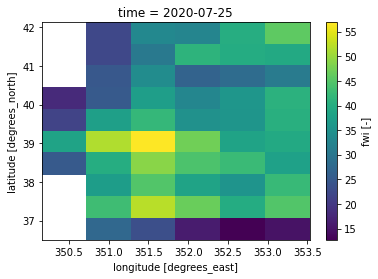

In [20]:
da_e5_en = ds_e5_en.fwi
fwi_e5_en = da_e5_en.loc[dict(lat = lat_slice, lon = lon_slice)]
fwi_e5_en[0].plot();

To get an idea of how different the 10 ensemble realisations are, we can look are the mean and spread (standard deviation) of the ensemble.

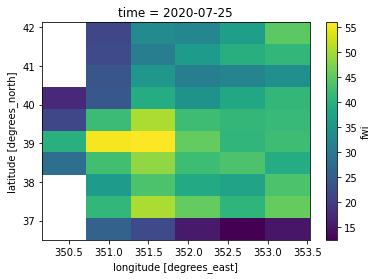

In [21]:
# Calculate mean, then plot
mean_fwi = fwi_e5_en.mean(dim = "member")
mean_fwi.plot()

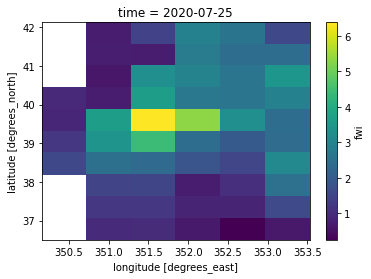

In [22]:
# Calculate spread (standard deviation), then plot
std_fwi = fwi_e5_en.std(dim = "member")
std_fwi.plot()

In the next tutorials we will skip over the operations above, as sample data are provided already cropped to the region of interest. Also ensemble mean and spread can be requested directly from the data provider. 

<a href="./00_index.ipynb"><< Index</a><br>
<a href="./51_CAMS_GFAS_FRPFIRE.ipynb"><< 51 - CAMS GFAS FRFPFIRE </a><span style="float:right;"><a href="./62_CEMS_GEFF_FWI_harmonized_danger_classes.ipynb">62 - CEMS GEFF FWI harmonized danger classes >></a></span>

<hr>

<img src='./img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under the <a href="./LICENSE">MIT License</a> and is developed under a Copernicus contract.